# Creating custom blocks

All blocks in Collimator inherit from the base `LeafSystem` class. In order to implement a custom block, we can inherit from this base class and implement the functionality of the block. Before discussing implementation of LeafSystems, it is useful to know the the following subclasses of `LeafSystem` available for quick implementation of specific types of blocks. These are:

1. `SourceBlock`: For implementing source blocks, with no input and one time-dependent output. To implement a source block, we can inherit from this class and initiliaze the base class with a callback function to evaluate the source function. For example, to implement a source $f(t) = a \sin(t) + \cos(b t)$, one may write:
```python
class SinePlusCosine(SourceBlock):
    def __init__(self):
        super().__init__(self._callback, a, b, **kwargs)
        self.declare_dynamic_parameter("a", a)
        self.declare_dynamic_parameter("b", b)
    
    def _callback(self, t, **parameters):
        a = parameters["a"]
        b = parameters["b"]
        return a*jnp.sin(t) + jnp.cos(b*t)
```

Declaring parameters is necessary if (i) automatic differentiation with respect to these parameters is required; or (i) the parmaeters need to be updated in the context. If these are not necessary requirements, the parameters can be stored as instance attributes and accessed in the callback function.


2. `FeedthroughBlock`: For implementing feedthrough blocks, with one input and one output, where the output is a function of the input alone. To implement a feedthrough block, we can inherit from this class and initalize the base class with a callback function to evaluate the feedthrough function. For example, to implement a feedthrough block with output $y(t) = a e^{-b x(t)}$, one may write:
```python
class ExponentialFeedthrough(FeedthroughBlock):
    def __init__(self):
        super().__init__(self._callback, a, b, **kwargs)
        self.declare_dynamic_parameter("a", a)
        self.declare_dynamic_parameter("b", b)
    
    def _callback(self, x, **parameters):
        a = parameters["a"]
        b = parameters["b"]
        return a*jnp.exp(-b*x)
```

3. `ReduceBlock`: For implementing reduce blocks, with multiple inputs and one output, where the output is a function of the inputs. To implement a reduce block, we can inherit from this class and initalize the base class with the number of inputs and a callback function to evaluate the reduce function. For example, to implement a reduce block with inputs $A(t)$ and $b(t)$, and where the output $x(t)$ is the solution of a full-rank matrix equation $A(t) x(t) = b(t)$ at time $t$, one may write:

```python
class LinearAlgebraSolve(ReduceBlock):
    def __init__(self):
        super().__init__(2, self._callback, **kwargs)
    
    def _callback(self, inputs, **parameters):
        A = inputs[0]
        b = inputs[1]
        return jnp.linalg.solve(A, b)
```

## LeafSystem implementation

In order to implement blocks with states, we need to inherit from the `LeafSystem` class. While we refer to the documentation of the `LeafSystem` class for full details, here we provide an overview of how to implement some basic continuous-time and discrete-time blocks.

### Input ports
To delcare an input port, we use the `declare_input_port` method, and optionally pass it a name parameter. The value of the input at this port can be a scalar, vector, or matrix. For example, to declare an input port we can write `self.declare_input_port(name="x")` in the initiializer of the LeafSystem subclass. We can use declare as many inputs as required; their ordering in the block will follow the ordering of declaration.

### Parameters

To declare a parameter, we use the `declare_dynamic_parameter` method, and pass it a key-value pair. The value of the parameter can be a scalar, vector, or matrix. For example, to declare a parameter $a$ with a scalar valur of 1.0, we can write `self.declare_dynamic_parameter("a", 1.0)` in the initializer of the LeafSystem subclass. These parameters can be used in the callback functions (see below). We can declare as many parameters as required. The advantage of declaring parameters, as opposed to storing them as instance attributes, is that the simulation output can be automatically differentiated with respect to the parameters. Furthremore, the declaration as parameters places them in the `context` and thus, allows their update in the context.

### States
#### Continuous states 
To declare a continuous state, we use the `declare_continuous_state` method, and pass it a default value and a callback function to evaluate the time derivative of the state. The value of the state can be a scalar, vector, or matrix. For example, to declare a continuous state-vector with two components, we can write `self.declare_continuous_state(default_value=jnp.array([1.0, 0.0]), ode=self.ode_callback)` in the initializer of the LeafSystem subclass. For more options, please see the LeafSystem documentation. The callback function should take `time, state, *inputs, **parameters` as arguments, and return the time derivative of the declared continuous state at `time`. 

#### Discrete states

To declare a discrete state, we use the `declare_discrete_state` method, and pass it a default value. The value of the state can be a scalar, vector, or matrix. For example, to declare a discrete state-vector of two components we can write `self.declare_discrete_state(default_value=jnp.array([1.0, 0.0]))` in the initializer of the LeafSystem subclass. The value of the discrete state is updated by events (periodic, zero crossing, etc.), which are discussed below.

The above was an example of a single numeric discrete state. In general, a discrete state may have multiple components of different data types. These are implemented as NamedTuples in Collimator. Please see documentation to learn more about this feature.

**Note**: A system (LeafSystem or a Diagram) can have a combination of continuous and discrete states. Collimator, as a hybrid systems modelling tool, does not put any restrictions on this aspect.

### Events

Events can be delcared using the `declare_periodic_update` and `declare_zero_crossing` methods. These events can be used to update the discrete state. For example, to declare a periodic event that, we can write `self.declare_periodic_update(period=1.0, event=self.periodic_event_callback)` in the initializer of the LeafSystem subclass. The callback function will be called every `period` seconds to update the discrete state. The callback function should take `time, state, *inputs, **parameters` as arguments, and return the updated state. Please see documentation for more options and zero crossing events.


### Output ports

To declare an output port, we use the `declare_output_port` method, and optionally pass it a name parameter. The value of the output at this port can be a scalar, vector, or matrix. For example, to declare an output port we can write `self.declare_output_port(self._eval_output_callback, name="y")` in the initializer of the LeafSystem subclass. The callback function should take `time, state, *inputs, *parameters` as arguments, and return the value of the output at that `time`. To output the full continuous state as an output, we can also use the `declare_continuous_state_output` method as a convenience.

The output port can behave as a feedthrough block (default), or a discrete block if one passes an additional `period` parameter to `declare_output_port`. In the latter case, the output port will only update at an interval of `period` and hold its output between updates.

## Putting it all together

### LeafSystem with continuous state
Let's implement a simple damped pendulum block as an example of a LeafSystem with continuous state. The pendulum dynamics are
\begin{equation}
\begin{bmatrix}
\dot{\theta} \\ \dot{\omega}
\end{bmatrix} = 
\begin{bmatrix}
\omega \\ -\dfrac{g}{L} \sin(\theta) - \dfrac{b}{m L^2} \omega +  \dfrac{u}{m L^2}
\end{bmatrix}.
\end{equation}

The pendulum block has a continuous vector state of size 2 (angle $\theta$ and angular velocity $\omega = \dot{\theta}$) and a torque input $u=\tau$. The pendulum parameters are mass $m$, length $L$, damping coefficients $b$, and acceleration due to gravity $g$. The output of the block can is either the full state ($[\theta, \omega]$) or just $\theta$ depending on user configuration.

In [1]:
import jax.numpy as jnp
from collimator.framework import LeafSystem


class Pendulum(LeafSystem):
    def __init__(
        self,
        *args,
        x0=[1.0, 0.0],
        m=1.0,
        g=9.81,
        L=1.0,
        b=0.0,
        full_state_output=True,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        # Declare parameters
        self.declare_dynamic_parameter("m", m)
        self.declare_dynamic_parameter("g", g)
        self.declare_dynamic_parameter("L", L)
        self.declare_dynamic_parameter("b", b)

        # Declare continuous state; it's default value indicates that its size is 2
        # the attached ode callback should return the derivative of the state
        self.declare_continuous_state(default_value=jnp.array(x0), ode=self.ode)

        # Declare input port for the torque
        self.declare_input_port(name="u")

        if full_state_output:
            # Declare output port for the full state
            self.declare_continuous_state_output(name="x")
        else:

            def _observation_callback(time, state, *inputs, **parameters):
                return state.continuous_state[0]  # output only theta

            self.declare_output_port(
                _observation_callback,
                name="y",
                requires_inputs=False,
            )

    def ode(self, time, state, *inputs, **parameters):
        # Get theta and omega from the continuous part of LeafSystem state
        theta, omega = state.continuous_state

        # Get parameters
        m = parameters["m"]
        g = parameters["g"]
        L = parameters["L"]
        b = parameters["b"]

        # Get input
        tau = inputs[0]

        # Reshape to scalar if input was an array
        tau = jnp.reshape(tau, ())

        # Compute the time derivative of the state (ODE RHS)
        dot_theta = omega
        mLsq = m * L * L
        dot_omega = -(g / L) * jnp.sin(theta) - b * omega / mLsq + tau / mLsq

        # Return the derivative of the state
        return jnp.array([dot_theta, dot_omega])

We can now simulate the system in the same manner as primitive blocks.

In [2]:
import collimator
from collimator.library import Sine
from collimator.simulation import SimulatorOptions

import matplotlib.pyplot as plt

pendulum = Pendulum(full_state_output=True, name="pendulum")
pendulum.input_ports[0].fix_value(0.0)

context = pendulum.create_context()

recorded_signals = {"x": pendulum.output_ports[0]}

sol = collimator.simulate(
    pendulum,
    context,
    (0.0, 10.0),
    recorded_signals=recorded_signals,
    options=SimulatorOptions(max_minor_step_size=0.1),
)

Initialized callback pendulum:pendulum_ode with prereqs [1, 2, 8]
Initialized callback pendulum:u with prereqs []
Initialized callback pendulum:x with prereqs [2]


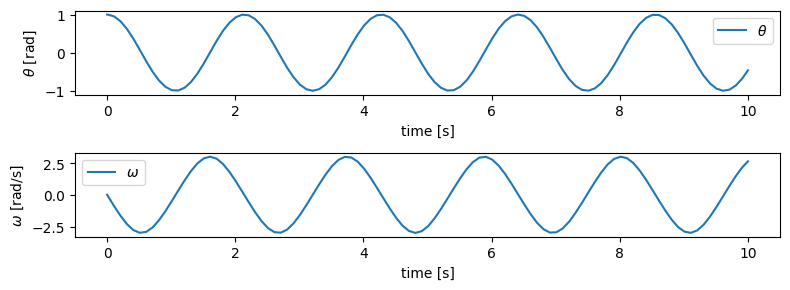

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 3))
ax1.plot(sol.time, sol.outputs["x"][:, 0], label=r"$\theta$")
ax2.plot(sol.time, sol.outputs["x"][:, 1], label=r"$\omega$")
ax1.set_xlabel("time [s]")
ax1.set_ylabel(r"$\theta$ [rad]")
ax2.set_xlabel("time [s]")
ax2.set_ylabel(r"$\omega$ [rad/s]")
ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()

We can also include the pendulum as part of larger diagrams. For example, we can create a sinusoidal torque input and connect it to the input port of the pendulum.

In [4]:
sine = Sine(amplitude=0.1, name="sine")
pendulum = Pendulum(x0=jnp.array([0.0, 0.0]), full_state_output=False, name="pendulum")

builder = collimator.DiagramBuilder()
builder.add(sine)
builder.add(pendulum)

builder.connect(sine.output_ports[0], pendulum.input_ports[0])

diagram = builder.build()

context = diagram.create_context()

recorded_signals = {"x": pendulum.output_ports[0], "u": sine.output_ports[0]}

sol = collimator.simulate(
    diagram,
    context,
    (0.0, 10.0),
    recorded_signals=recorded_signals,
    options=SimulatorOptions(max_minor_step_size=0.1),
)

Initialized callback sine:out_0 with prereqs [1]
Initialized callback pendulum:pendulum_ode with prereqs [1, 2, 8]
Initialized callback pendulum:u with prereqs []
Initialized callback pendulum:y with prereqs [0]


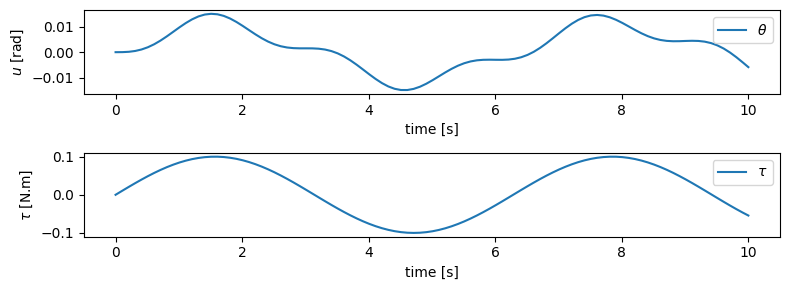

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 3))
ax1.plot(sol.time, sol.outputs["x"], label=r"$\theta$")
ax1.set_xlabel("time [s]")
ax1.set_ylabel("$u$ [rad]")
ax1.legend()
ax2.plot(sol.time, sol.outputs["u"], label=r"$\tau$")
ax2.set_xlabel("time [s]")
ax2.set_ylabel("$\\tau$ [N.m]")
ax2.legend()
fig.tight_layout()
plt.show()

### LeafSystem with discrete state
Let's implement the Henon map as an example of a LeafSystem with discrete state. The Henon map dynamics are

\begin{align}
x_{n+1} &= 1 - a x_n^2 + y_n, \\
y_{n+1} &= b x_n.
\end{align}

with two states $x_n$ and $y_n$, and two paramters $a$ and $b$. We'll represent the discrete state as $s_n = [x_n, y_n]$.

In [6]:
class HenonMap(LeafSystem):
    def __init__(
        self,
        *args,
        dt=1.0,
        a=1.4,
        b=0.3,
        s0=jnp.array([0.1, 0.3]),
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        # Declare parameters
        self.declare_dynamic_parameter("a", a)
        self.declare_dynamic_parameter("b", b)

        # Declare discrete state; it's default value indicates that its size is 2
        self.declare_discrete_state(default_value=s0)

        # Declare periodic event
        self.declare_periodic_update(self._update, period=dt, offset=0.0)

        # Declare output port
        self.declare_output_port(
            self._eval_output,
            name="s",
            period=dt,
            offset=0.0,
            default_value=s0,
            requires_inputs=False,
        )

    def _update(self, time, state, *inputs, **parameters):
        # Get xn and yn from the discrete part of LeafSystem state
        sn = state.discrete_state
        xn = sn[0]
        yn = sn[1]

        # Get parameters
        a = parameters["a"]
        b = parameters["b"]

        xn_plus = 1.0 - a * xn**2 + yn
        yn_plus = b * xn

        # Return the updated state
        return jnp.array([xn_plus, yn_plus])

    def _eval_output(self, time, state, *inputs, **parameters):
        # Get theta and omega from the continuous part of LeafSystem state
        return state.discrete_state

In [7]:
henon_map = HenonMap(name="henon_map")

context = henon_map.create_context()

recorded_signals = {"s": henon_map.output_ports[0]}

sol = collimator.simulate(
    henon_map, context, (0.0, 10000.0), recorded_signals=recorded_signals
)

Initialized callback henon_map:s with prereqs [0]


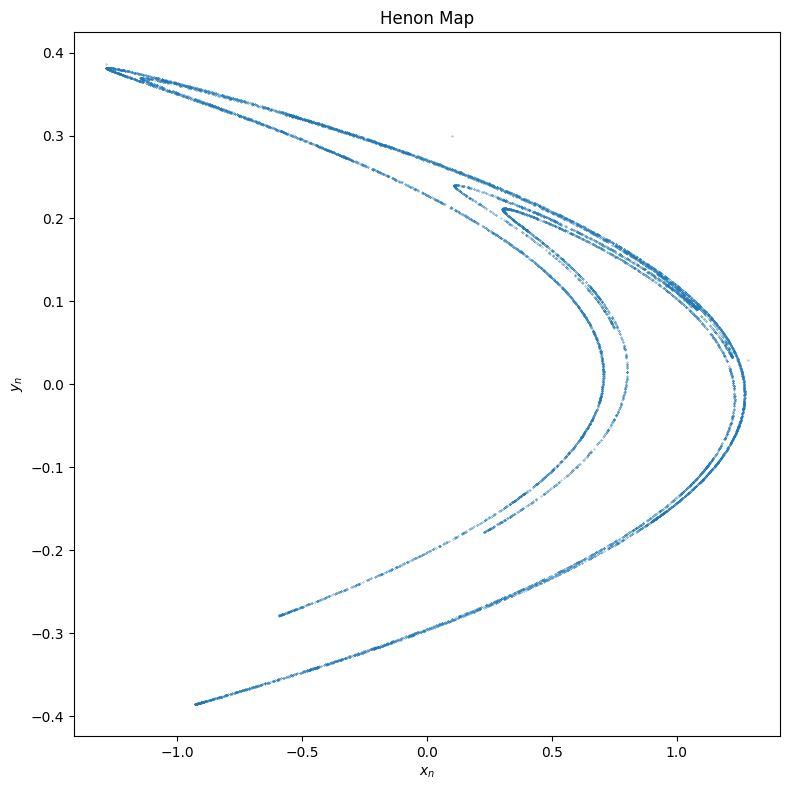

In [8]:
xn_sol = sol.outputs["s"][:, 0]
yn_sol = sol.outputs["s"][:, 1]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(xn_sol, yn_sol, ".", markersize=0.5)
ax.set_xlabel(r"$x_n$")
ax.set_ylabel(r"$y_n$")
ax.set_title("Henon Map")
fig.tight_layout()
plt.show()

We can observe the chaotic sytem in the plot above. Placing parameters in the context allows us to re-simulate the system with different parameters conveniently.

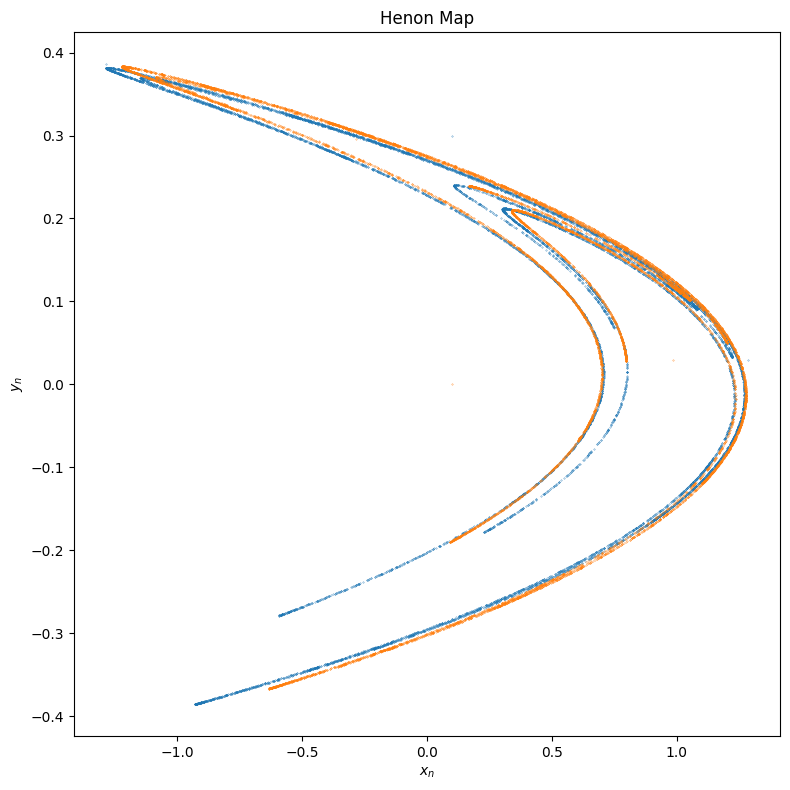

In [9]:
# update parameters
henon_sub_context = context[henon_map.system_id].with_parameters({"a": 1.35, "b": 0.3})
context = context.with_subcontext(henon_map.system_id, henon_sub_context)

# update initial state
context = context.with_discrete_state(jnp.array([0.1, 0.0]))

# simulate and plot
sol = collimator.simulate(
    henon_map, context, (0.0, 10000.0), recorded_signals=recorded_signals
)

xn_sol_new = sol.outputs["s"][:, 0]
yn_sol_new = sol.outputs["s"][:, 1]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(xn_sol, yn_sol, ".", markersize=0.5)
ax.plot(xn_sol_new, yn_sol_new, ".", markersize=0.5)
ax.set_xlabel(r"$x_n$")
ax.set_ylabel(r"$y_n$")
ax.set_title("Henon Map")
fig.tight_layout()
plt.show()

The discrete-time LeafSystem we have created can now be used as a component in larger diagrams.